In [2]:
# select a GPU
import os
print(os.getcwd())

import datetime
os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"] = "0"

/mounts/ud3/contractors/jtaylor/acoustic_scene_classification/LateFusion


In [3]:
#imports 
import numpy as np
import h5py
import scipy.io
from sklearn.metrics import confusion_matrix
from sklearn.decomposition import PCA
import pandas as pd
from DCASE_plots import plot_confusion_matrix

import pickle
import librosa
import soundfile as sound
import tensorflow
import keras
import pickle

print("Librosa version = ",librosa.__version__)
print("Pysoundfile version = ",sound.__version__)
print("keras version = ",keras.__version__)
print("tensorflow version = ",tensorflow.__version__)

print(tensorflow.test.is_built_with_cuda())
print(tensorflow.config.list_physical_devices('GPU'))


Librosa version =  0.10.1
Pysoundfile version =  0.12.1
keras version =  2.8.0
tensorflow version =  2.8.0
True
[]


2023-11-14 18:23:10.412546: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudnn.so.8'; dlerror: libcudnn.so.8: cannot open shared object file: No such file or directory
2023-11-14 18:23:10.412590: W tensorflow/core/common_runtime/gpu/gpu_device.cc:1850] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...


In [1]:
#Task 1a dev validation set
base_path = '../data/CochlScene/'
test_path = base_path + 'Test/'
fold_path = base_path + 'test_fold.tsv'

In [22]:
sr = 44100
SampleDuration = 10
NumFreqBins = 128
NumFFTPoints = 2048
HopLength = int(NumFFTPoints/2)
NumTimeBins = int(np.ceil(SampleDuration*sr/HopLength))
print(NumTimeBins)

#load filenames and labels
dev_test_df = pd.read_csv(fold_path,sep='\t', encoding='ASCII')
wavpaths = dev_test_df['filename'].tolist()
ClassNames = np.unique(dev_test_df['scene_label'])
y_val_labels =  dev_test_df['scene_label'].astype('category').cat.codes.values

print(wavpaths)
print(ClassNames)
print(y_val_labels)

#swap codes for 2 and 1 to match the DCASE ordering of classes
a1=np.where(y_val_labels==2)
a2=np.where(y_val_labels==3)
y_val_labels.setflags(write=1)
y_val_labels[a1] = 3
y_val_labels[a2] = 2

431
['Street/Street_user0472_14824272_005.wav', 'Street/Street_user0281_14826474_001.wav', 'Street/Street_user0524_14835736_000.wav', 'Street/Street_user0281_14826379_000.wav', 'Street/Street_user0019_14824964_001.wav', 'Street/Street_user0472_14824272_002.wav', 'Street/Street_user0758_14838834_002.wav', 'Street/Street_user0383_14828643_002.wav', 'Street/Street_user0524_14835648_003.wav', 'Street/Street_user0281_14826412_003.wav', 'Street/Street_user0586_14833369_002.wav', 'Street/Street_user0567_14841095_005.wav', 'Street/Street_user0356_14847987_002.wav', 'Street/Street_user0586_14833369_005.wav', 'Street/Street_user0567_14841095_002.wav', 'Street/Street_user0356_14847987_005.wav', 'Street/Street_user0758_14838834_005.wav', 'Street/Street_user0383_14828643_005.wav', 'Street/Street_user0524_14835648_004.wav', 'Street/Street_user0281_14825593_000.wav', 'Street/Street_user0465_14834748_001.wav', 'Street/Street_user0281_14826412_004.wav', 'Street/Street_user0254_14823497_005.wav', 'Stree

In [23]:
#load wav files and get log-mel spectrograms, deltas, and delta-deltas
def deltas(X_in):
    X_out = (X_in[:,:,2:,:]-X_in[:,:,:-2,:])/10.0
    X_out = X_out[:,:,1:-1,:]+(X_in[:,:,4:,:]-X_in[:,:,:-4,:])/5.0
    return X_out

LM_val = np.zeros((len(wavpaths),NumFreqBins,NumTimeBins,2),'float32')
print(LM_val.shape)
for i in range(len(wavpaths)):
    stereo,fs = sound.read(test_path + wavpaths[i],stop=SampleDuration*sr)

    # This is a bit hacky but the model expects a spectrogram for each channel
    # Instead I am just giving it two of the same spectrogram
    for channel in range(2):
        LM_val[i,:,:,channel]= librosa.feature.melspectrogram(y=stereo[:], 
                                       sr=sr,
                                       n_fft=NumFFTPoints,
                                       hop_length=HopLength,
                                       n_mels=NumFreqBins,
                                       fmin=0.0,
                                       fmax=sr/2,
                                       htk=True,
                                       norm=None)

LM_val=np.log(LM_val)
LM_deltas_val = deltas(LM_val)
LM_deltas_deltas_val = deltas(LM_deltas_val)
LM_val = np.concatenate((LM_val[:,:,4:-4,:],LM_deltas_val[:,:,2:-2,:],LM_deltas_deltas_val),axis=-1)

with open("../data/CochlScene/features/LF_features.pckl", 'wb') as pickle_file:
    pickle.dump(LM_val, pickle_file, protocol=4)

(7687, 128, 431, 2)


/work/contractors/jtaylor/.conda/envs/late_fusion/lib/python3.7/site-packages/ipykernel_launcher.py:23: RuntimeWarning: divide by zero encountered in log
/work/contractors/jtaylor/.conda/envs/late_fusion/lib/python3.7/site-packages/ipykernel_launcher.py:3: RuntimeWarning: invalid value encountered in subtract
  This is separate from the ipykernel package so we can avoid doing imports until
/work/contractors/jtaylor/.conda/envs/late_fusion/lib/python3.7/site-packages/ipykernel_launcher.py:4: RuntimeWarning: invalid value encountered in subtract
  after removing the cwd from sys.path.


In [24]:
with open("../data/CochlScene/features/LF_features.pckl", 'rb') as pickle_file:
    LM_val = pickle.load(pickle_file)

In [25]:
print(LM_val.shape)

(7687, 128, 423, 6)


In [26]:
#load and run the model
best_model = keras.models.load_model('pretrained_models/DCASE_Task1a_development.h5')
# print(best_model.summary())
y_pred_val = np.argmax(best_model.predict(LM_val),axis=1)

2023-11-15 10:07:06.762544: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-11-15 10:07:08.136727: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 9988918272 exceeds 10% of free system memory.


overall accuracy:  0.822700119474313
Normalized confusion matrix
[[310   0  27   0   0   0  61  22   1   0]
 [  0 368   0  18   2   0   0   0   0  27]
 [ 13   2 351  18   2   5  28   5   2   9]
 [  0  10  10 353   0   0   0   0   0  60]
 [  0   0   0   0 351  28   0   0   7   0]
 [  0   0   0   1  20 271   2  22  71   0]
 [ 41   0  32   0   0   0 356  12   0   0]
 [ 18   1   8   0   1  17  17 352  15   0]
 [  0   0   0   0   6  15   0   5 376   0]
 [  0  40   0  41   0   0   0   0   0 355]]
per-class accuracy (recall):  [0.73634204 0.88674699 0.80689655 0.81524249 0.90932642 0.7002584
 0.80725624 0.82051282 0.93532338 0.81422018]
per-class precision:  [0.81151832 0.87410926 0.82009346 0.81902552 0.91884817 0.80654762
 0.76724138 0.84210526 0.79661017 0.78713969]
mean per-class recall:  0.82321255223722
mean per-class precision:  0.824323885637634


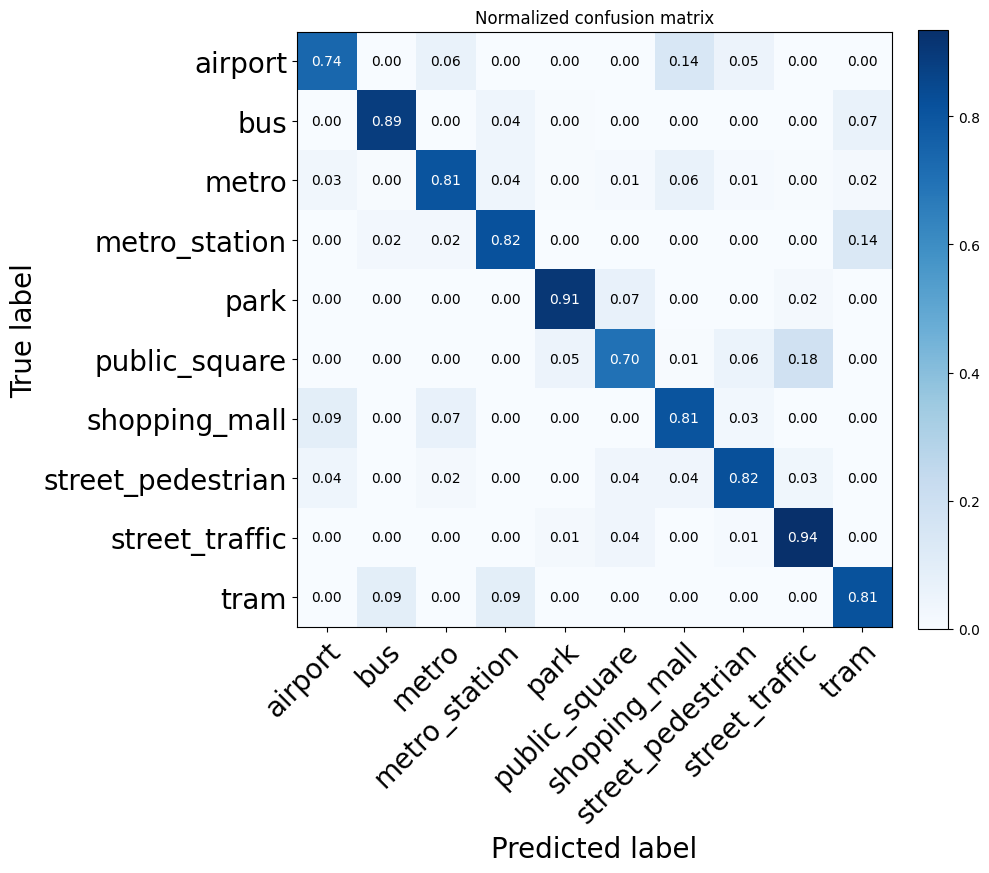

In [17]:
import seaborn as sns
import matplotlib.pyplot as plt

DCASE_ClassNames = ['airport', 'bus', 'metro', 'metro_station', 'park', 'public_square',
 'shopping_mall', 'street_pedestrian', 'street_traffic', 'tram']

# get confusion matrix
conf_matrix = confusion_matrix(y_val,y_pred_val)
conf_matrix = np.delete(conf_matrix, np.s_[-3:], axis=1)
conf_mat_norm_recall = conf_matrix.astype('float32')/conf_matrix.sum(axis=1)[:,np.newaxis]
recall_by_class = np.diagonal(conf_mat_norm_recall)
mean_recall = np.mean(recall_by_class)

# Calculate row sums to use for percentages
row_sums = conf_matrix.sum(axis=1)

# Calculate percentages
percentages = (conf_matrix.T / row_sums).T  # Transpose for division, then transpose back

# Format percentages as strings with '%' symbol
annot_data = [['{:.2f}'.format(val) for val in row] for row in percentages]
annot_data = [['' if float(val <= 0.04) else '{:.2f}'.format(val) for val in row] for row in percentages]

plt.figure(dpi=200)

annot_kws = {'size': 6}
ax = sns.heatmap(percentages, xticklabels=DCASE_ClassNames, yticklabels=ClassNames, annot=annot_data, fmt='', square=True, cmap='Blues', annot_kws=annot_kws)
ax.set_xlabel('Predicted Label')
ax.set_xticklabels(ax.get_xticklabels(), rotation = 90)
ax.set_ylabel('True Label')

#plt.subplots_adjust(left=0.2, bottom=0.35)
plt.show()

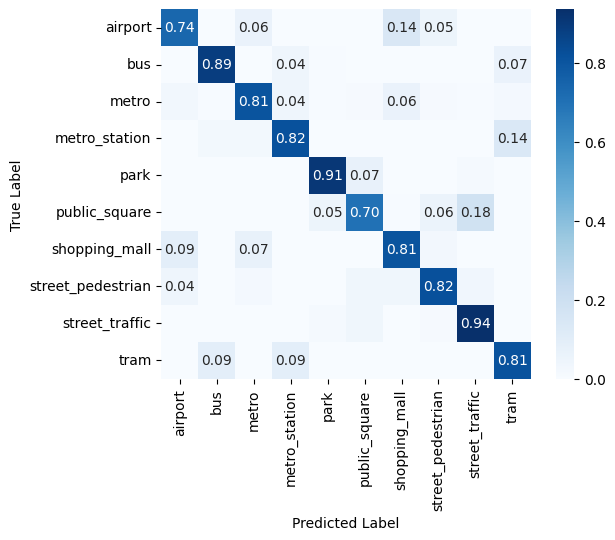

<Figure size 2560x1920 with 0 Axes>

In [21]:
import seaborn as sns

# Calculate row sums to use for percentages
row_sums = conf_matrix.sum(axis=1)

# Calculate percentages
percentages = (conf_matrix.T / row_sums).T  # Transpose for division, then transpose back

# Format percentages as strings with '%' symbol
annot_data = [['{:.2f}'.format(val) for val in row] for row in percentages]
annot_data = [['' if float(val <= 0.04) else '{:.2f}'.format(val) for val in row] for row in percentages]

annot_kws = {'size': 10}
ax = sns.heatmap(percentages, xticklabels=ClassNames, yticklabels=ClassNames, annot=annot_data, fmt='', square=True, cmap='Blues', annot_kws=annot_kws)
ax.set_xlabel('Predicted Label')
ax.set_xticklabels(ax.get_xticklabels(), rotation = 90)
ax.set_ylabel('True Label')

plt.figure(dpi=400)
plt.subplots_adjust(left=0.2, bottom=0.35)
plt.show()